K0：

开始针对 Media Port 的 K0 灵敏性分析 (Base: 9.32)...
正在计算工况 -15%: K0 = 7.9220
正在计算工况 -10%: K0 = 8.3880
正在计算工况 -5%: K0 = 8.8540
正在计算工况 Base: K0 = 9.3200
正在计算工况 +5%: K0 = 9.7860
正在计算工况 +10%: K0 = 10.2520
正在计算工况 +15%: K0 = 10.7180


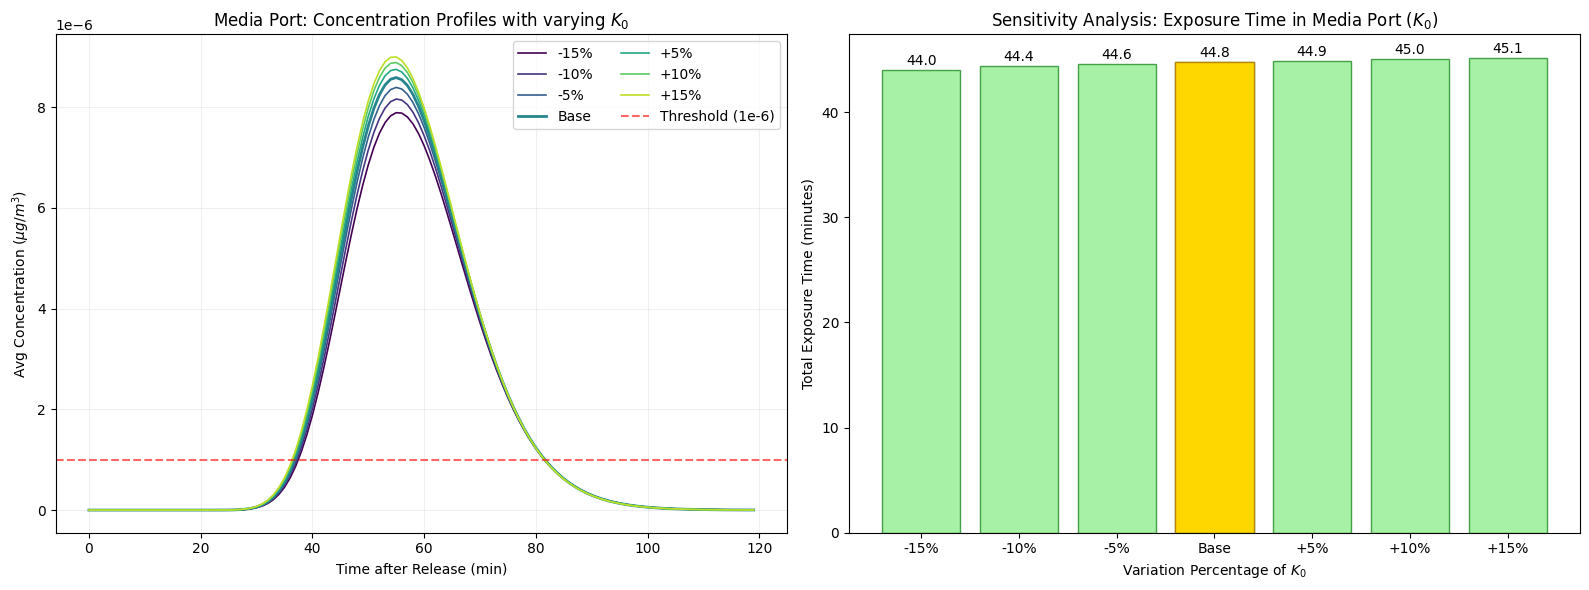


--- K0 灵敏性分析结果汇总 (Media Port) ---
Variation  K0_Value  Exposure_Time_Min
     -15%     7.922              44.05
     -10%     8.388              44.35
      -5%     8.854              44.60
     Base     9.320              44.80
      +5%     9.786              44.90
     +10%    10.252              45.05
     +15%    10.718              45.15


In [5]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# ================= 1. 模拟引擎函数化 (针对 K0 暴露时长优化) =================
def simulate_K0_exposure(K0_target, threshold=1e-6):
    """
    K0_target: 待测试的基础扩散系数
    threshold: 暴露浓度阈值
    """
    dx, dy, dz = 20, 20, 10
    nx, ny, nz = 101, 101, 71
    dt = 3.0   
    total_time = 7200  
    steps = int(total_time / dt)
    
    x_vec = np.linspace(-1000, 1000, nx)
    y_vec = np.linspace(-1000, 1000, ny)
    X, Y = np.meshgrid(x_vec, y_vec, indexing='ij')

    # Media Port 的地理边界掩码
    mp_bounds = {"x": [-550, -300], "y": [0, 200]}
    mp_mask = (X >= mp_bounds["x"][0]) & (X <= mp_bounds["x"][1]) & \
              (Y >= mp_bounds["y"][0]) & (Y <= mp_bounds["y"][1])

    # 建筑物场构建
    buildings_cfg = [
        {"name": "Media Port", "x": -420, "y": 80, "A": 2.5, "R": 150},
        {"name": "PR North", "x": 480, "y": 220, "A": 2.0, "R": 120},
        {"name": "PR East", "x": 550, "y": -120, "A": 2.2, "R": 180},
        {"name": "Boyawan", "x": -280, "y": -380, "A": 1.8, "R": 130},
        {"name": "Dijing Huayuan", "x": -550, "y": -250, "A": 2.1, "R": 140}
    ]
    Fbld = np.ones((nx, ny))
    for b in buildings_cfg:
        Fbld += b['A'] * np.exp(-((X - b['x'])**2 + (Y - b['y'])**2) / b['R']**2)

    # 扩散张量计算
    theta, alpha = np.deg2rad(131.8), 0.4
    Kx_2d = K0_target * (np.cos(theta)**2 + alpha * np.sin(theta)**2) * Fbld
    Ky_2d = K0_target * (np.sin(theta)**2 + alpha * np.cos(theta)**2) * Fbld
    Kz_vec = 2.0 * (1 - np.exp(-np.linspace(0, 700, nz) / 20.0))

    Kx = np.repeat(Kx_2d[:, :, np.newaxis], nz, axis=2)
    Ky = np.repeat(Ky_2d[:, :, np.newaxis], nz, axis=2)
    Kz = np.tile(Kz_vec, (nx, ny, 1))

    # 初始化浓度与统计量
    C = np.zeros((nx, ny, nz))
    C[nx//2, ny//2, int(600/dz)] = 1e15 / (dx*dy*dz) 
    
    exposure_count = 0 
    concentration_history = []

    # 时间步迭代
    for s in range(steps):
        C_old = C.copy()
        term_x = (Kx[1:-1, 1:-1, 1:-1] * (C_old[2:, 1:-1, 1:-1] - 2*C_old[1:-1, 1:-1, 1:-1] + C_old[:-2, 1:-1, 1:-1])) / dx**2
        term_y = (Ky[1:-1, 1:-1, 1:-1] * (C_old[1:-1, 2:, 1:-1] - 2*C_old[1:-1, 1:-1, 1:-1] + C_old[1:-1, :-2, 1:-1])) / dy**2
        term_z = (Kz[1:-1, 1:-1, 1:-1] * (C_old[1:-1, 1:-1, 2:] - 2*C_old[1:-1, 1:-1, 1:-1] + C_old[1:-1, 1:-1, :-2])) / dz**2

        C[1:-1, 1:-1, 1:-1] += dt * (term_x + term_y + term_z - 0.004 * C_old[1:-1, 1:-1, 1:-1])
        C[:, :, 0], C[:, :, -1] = C[:, :, 1], C[:, :, -2]

        # 采样 10m 高度（index 1）的平均浓度
        avg_c = np.mean(C[:, :, 1][mp_mask])
        
        # 暴露时长统计
        if avg_c > threshold:
            exposure_count += 1
            
        if s % 20 == 0:
            concentration_history.append(avg_c)
                
    exposure_time_min = (exposure_count * dt) / 60.0
    return exposure_time_min, concentration_history

# ================= 2. 执行 K0 灵敏性分析 =================
K0_base = 9.32
variations = [-0.15, -0.10, -0.05, 0, 0.05, 0.10, 0.15]
labels = ["-15%", "-10%", "-5%", "Base", "+5%", "+10%", "+15%"]

k0_exposure_times = []
k0_concentration_curves = {}

print(f"开始针对 Media Port 的 K0 灵敏性分析 (Base: {K0_base})...")
for var, label in zip(variations, labels):
    target_k0 = K0_base * (1 + var)
    print(f"正在计算工况 {label}: K0 = {target_k0:.4f}")
    exp_time, curve = simulate_K0_exposure(target_k0)
    k0_exposure_times.append(exp_time)
    k0_concentration_curves[label] = curve

# ================= 3. 结果可视化展示 =================
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# 图1: 浓度时间序列曲线
time_axis = np.arange(len(k0_concentration_curves["Base"])) * 1.0 
colors = plt.cm.viridis(np.linspace(0, 0.9, len(labels))) # 使用 viridis 渐变色

for idx, label in enumerate(labels):
    ax1.plot(time_axis, k0_concentration_curves[label], label=label, 
             color=colors[idx], lw=2 if label=="Base" else 1.2)
ax1.axhline(1e-6, color='red', linestyle='--', alpha=0.6, label="Threshold (1e-6)")
ax1.set_title("Media Port: Concentration Profiles with varying $K_0$")
ax1.set_xlabel("Time after Release (min)")
ax1.set_ylabel("Avg Concentration ($\mu g/m^3$)")
ax1.legend(ncol=2)
ax1.grid(alpha=0.2)

# 图2: 暴露时长对比柱状图
bars = ax2.bar(labels, k0_exposure_times, color='lightgreen', edgecolor='forestgreen', alpha=0.8)
ax2.bar("Base", k0_exposure_times[3], color='gold', edgecolor='darkgoldenrod') # 突出基准
ax2.set_title("Sensitivity Analysis: Exposure Time in Media Port ($K_0$)")
ax2.set_ylabel("Total Exposure Time (minutes)")
ax2.set_xlabel("Variation Percentage of $K_0$")

# 在柱状图上方标注具体数值
for bar in bars:
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height + 0.2, f'{height:.1f}', ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show()

# ================= 4. 统计摘要打印 =================
df_k0_summary = pd.DataFrame({
    "Variation": labels,
    "K0_Value": [K0_base * (1+v) for v in variations],
    "Exposure_Time_Min": k0_exposure_times
})
print("\n--- K0 灵敏性分析结果汇总 (Media Port) ---")
print(df_k0_summary.to_string(index=False))

A:

开始建筑物系数 A 的灵敏性分析 (Media Port)...
正在计算 A 变动 -15% 的工况...
正在计算 A 变动 -10% 的工况...
正在计算 A 变动 -5% 的工况...
正在计算 A 变动 Base 的工况...
正在计算 A 变动 +5% 的工况...
正在计算 A 变动 +10% 的工况...
正在计算 A 变动 +15% 的工况...


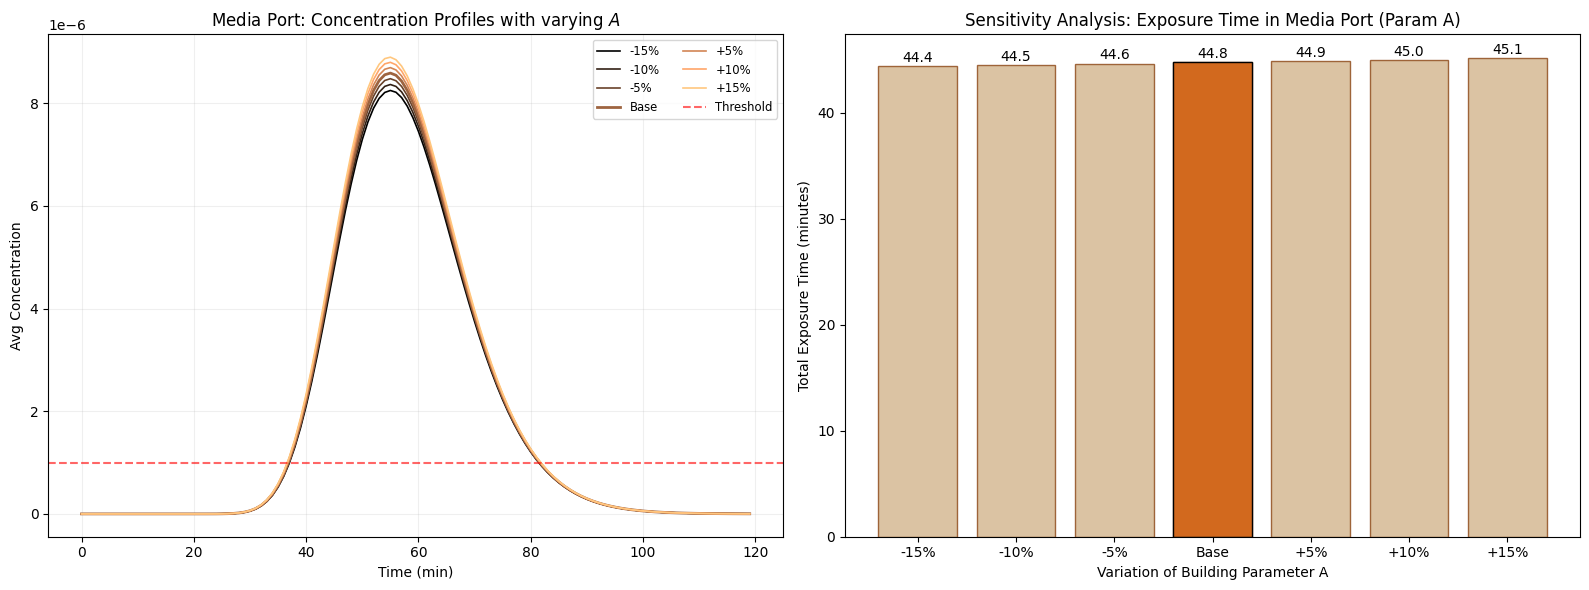


--- 建筑物 A 灵敏性分析汇总 (Media Port) ---
Variation  Exposure_Time_Min
     -15%              44.40
     -10%              44.50
      -5%              44.65
     Base              44.80
      +5%              44.90
     +10%              45.00
     +15%              45.15


In [6]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# ================= 1. 模拟引擎函数化 (针对 A 值的暴露时长优化) =================
def simulate_A_exposure(a_multiplier, threshold=1e-6):
    """
    a_multiplier: A值的缩放倍数，如 1.05 代表增加 5%
    threshold: 暴露浓度阈值
    """
    dx, dy, dz = 20, 20, 10
    nx, ny, nz = 101, 101, 71
    dt = 3.0   
    total_time = 7200  
    steps = int(total_time / dt)
    
    x_vec = np.linspace(-1000, 1000, nx)
    y_vec = np.linspace(-1000, 1000, ny)
    X, Y = np.meshgrid(x_vec, y_vec, indexing='ij')

    # Media Port 的地理边界掩码
    mp_bounds = {"x": [-550, -300], "y": [0, 200]}
    mp_mask = (X >= mp_bounds["x"][0]) & (X <= mp_bounds["x"][1]) & \
              (Y >= mp_bounds["y"][0]) & (Y <= mp_bounds["y"][1])

    # 原始建筑物配置
    base_buildings = [
        {"name": "Media Port", "x": -420, "y": 80, "A": 2.5, "R": 150},
        {"name": "PR North", "x": 480, "y": 220, "A": 2.0, "R": 120},
        {"name": "PR East", "x": 550, "y": -120, "A": 2.2, "R": 180},
        {"name": "Boyawan", "x": -280, "y": -380, "A": 1.8, "R": 130},
        {"name": "Dijing Huayuan", "x": -550, "y": -250, "A": 2.1, "R": 140}
    ]

    # 根据 a_multiplier 动态构建 Fbld 场
    Fbld = np.ones((nx, ny))
    for b in base_buildings:
        adjusted_A = b['A'] * a_multiplier
        Fbld += adjusted_A * np.exp(-((X - b['x'])**2 + (Y - b['y'])**2) / b['R']**2)

    # 固定其他物理参数
    K0, theta, alpha = 9.32, np.deg2rad(131.8), 0.4
    Kx_2d = K0 * (np.cos(theta)**2 + alpha * np.sin(theta)**2) * Fbld
    Ky_2d = K0 * (np.sin(theta)**2 + alpha * np.cos(theta)**2) * Fbld
    Kz_vec = 2.0 * (1 - np.exp(-np.linspace(0, 700, nz) / 20.0))

    Kx = np.repeat(Kx_2d[:, :, np.newaxis], nz, axis=2)
    Ky = np.repeat(Ky_2d[:, :, np.newaxis], nz, axis=2)
    Kz = np.tile(Kz_vec, (nx, ny, 1))

    # 初始化浓度
    C = np.zeros((nx, ny, nz))
    C[nx//2, ny//2, int(600/dz)] = 1e15 / (dx*dy*dz) 
    
    exposure_count = 0 
    concentration_history = []

    for s in range(steps):
        C_old = C.copy()
        term_x = (Kx[1:-1, 1:-1, 1:-1] * (C_old[2:, 1:-1, 1:-1] - 2*C_old[1:-1, 1:-1, 1:-1] + C_old[:-2, 1:-1, 1:-1])) / dx**2
        term_y = (Ky[1:-1, 1:-1, 1:-1] * (C_old[1:-1, 2:, 1:-1] - 2*C_old[1:-1, 1:-1, 1:-1] + C_old[1:-1, :-2, 1:-1])) / dy**2
        term_z = (Kz[1:-1, 1:-1, 1:-1] * (C_old[1:-1, 1:-1, 2:] - 2*C_old[1:-1, 1:-1, 1:-1] + C_old[1:-1, 1:-1, :-2])) / dz**2

        C[1:-1, 1:-1, 1:-1] += dt * (term_x + term_y + term_z - 0.004 * C_old[1:-1, 1:-1, 1:-1])
        C[:, :, 0], C[:, :, -1] = C[:, :, 1], C[:, :, -2]

        # 统计 Media Port 10m 平均浓度
        avg_c = np.mean(C[:, :, 1][mp_mask])
        if avg_c > threshold:
            exposure_count += 1
            
        if s % 20 == 0:
            concentration_history.append(avg_c)
                
    exposure_time_min = (exposure_count * dt) / 60.0
    return exposure_time_min, concentration_history

# ================= 2. 执行 A 值灵敏性分析 =================
variations = [-0.15, -0.10, -0.05, 0, 0.05, 0.10, 0.15]
labels = ["-15%", "-10%", "-5%", "Base", "+5%", "+10%", "+15%"]

a_exposure_times = []
a_concentration_curves = {}

print("开始建筑物系数 A 的灵敏性分析 (Media Port)...")
for var, label in zip(variations, labels):
    multiplier = 1 + var
    print(f"正在计算 A 变动 {label} 的工况...")
    exp_time, curve = simulate_A_exposure(multiplier)
    a_exposure_times.append(exp_time)
    a_concentration_curves[label] = curve

# ================= 3. 结果可视化展示 =================
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# 图1: 浓度时间曲线 (展示 A 变化带来的细微波动)
time_axis = np.arange(len(a_concentration_curves["Base"])) * 1.0 
colors = plt.cm.copper(np.linspace(0, 1, len(labels))) # 使用铜色系

for idx, label in enumerate(labels):
    ax1.plot(time_axis, a_concentration_curves[label], label=label, 
             color=colors[idx], lw=2 if label=="Base" else 1.2)
ax1.axhline(1e-6, color='red', linestyle='--', alpha=0.6, label="Threshold")
ax1.set_title("Media Port: Concentration Profiles with varying $A$")
ax1.set_xlabel("Time (min)")
ax1.set_ylabel("Avg Concentration")
ax1.legend(ncol=2, fontsize='small')
ax1.grid(alpha=0.2)

# 图2: 暴露时长柱状图
bars = ax2.bar(labels, a_exposure_times, color='tan', edgecolor='saddlebrown', alpha=0.8)
ax2.bar("Base", a_exposure_times[3], color='chocolate', edgecolor='black') # 突出基准
ax2.set_title("Sensitivity Analysis: Exposure Time in Media Port (Param A)")
ax2.set_ylabel("Total Exposure Time (minutes)")
ax2.set_xlabel("Variation of Building Parameter A")

# 标注数值
for bar in bars:
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height + 0.1, f'{height:.1f}', ha='center', va='bottom')

plt.tight_layout()
plt.show()

# ================= 4. 统计摘要 =================
df_a_summary = pd.DataFrame({
    "Variation": labels,
    "Exposure_Time_Min": a_exposure_times
})
print("\n--- 建筑物 A 灵敏性分析汇总 (Media Port) ---")
print(df_a_summary.to_string(index=False))

theta:

开始针对 Media Port 的 Theta 灵敏性分析...
运行模拟: Theta = 112.03° (-15%)
运行模拟: Theta = 118.62° (-10%)
运行模拟: Theta = 125.21° (-5%)
运行模拟: Theta = 131.80° (Base)
运行模拟: Theta = 138.39° (+5%)
运行模拟: Theta = 144.98° (+10%)
运行模拟: Theta = 151.57° (+15%)


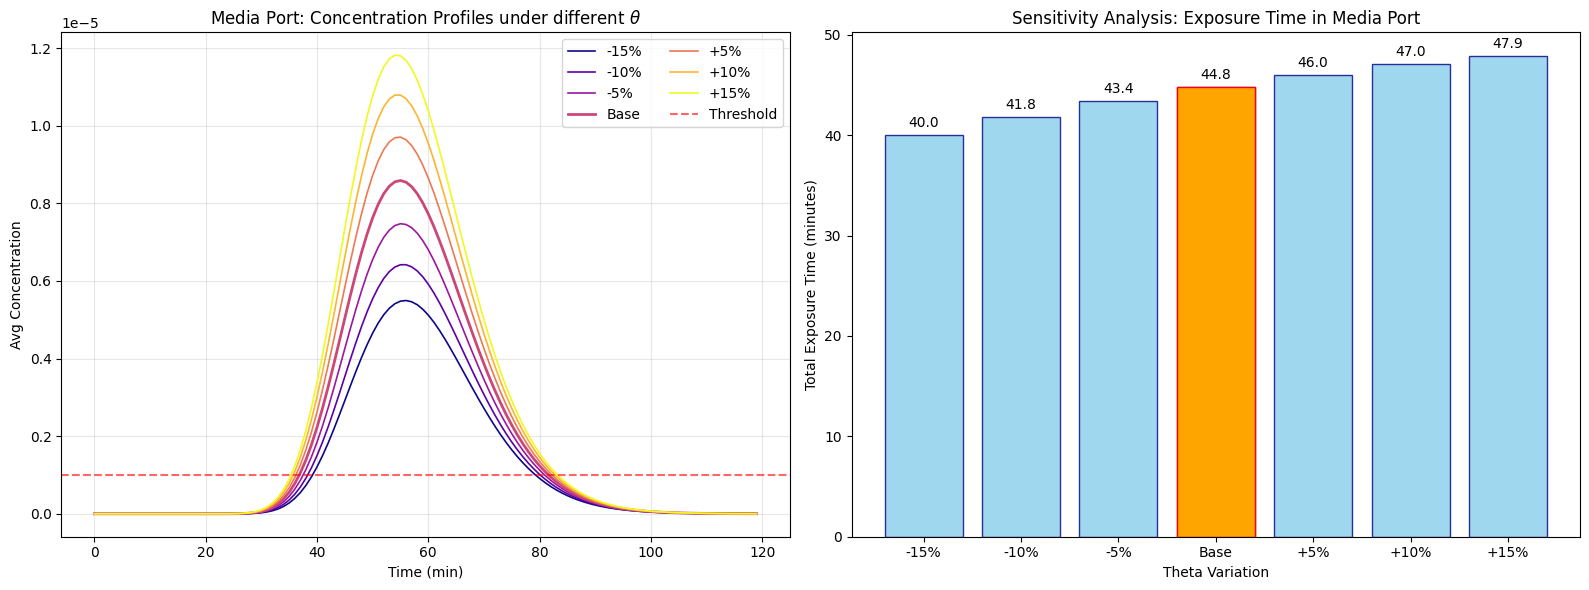


--- Media Port 暴露时长灵敏性分析汇总 ---
Variation  Theta_Value  Exposure_Time_Min
     -15%       112.03              40.05
     -10%       118.62              41.80
      -5%       125.21              43.40
     Base       131.80              44.80
      +5%       138.39              46.00
     +10%       144.98              47.05
     +15%       151.57              47.85


In [4]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# ================= 1. 模拟引擎函数化 (针对 Media Port 暴露时长优化) =================
def simulate_theta_exposure(theta_deg, threshold=1e-6):
    """
    theta_deg: 输入的风向角度
    threshold: 暴露浓度阈值
    """
    dx, dy, dz = 20, 20, 10
    nx, ny, nz = 101, 101, 71
    dt = 3.0   
    total_time = 7200  
    steps = int(total_time / dt)
    theta_rad = np.deg2rad(theta_deg)
    
    x_vec = np.linspace(-1000, 1000, nx)
    y_vec = np.linspace(-1000, 1000, ny)
    X, Y = np.meshgrid(x_vec, y_vec, indexing='ij')

    # 建筑物配置 (Base)
    buildings_cfg = [
        {"name": "Media Port", "x": -420, "y": 80, "A": 2.5, "R": 150},
        {"name": "PR North", "x": 480, "y": 220, "A": 2.0, "R": 120},
        {"name": "PR East", "x": 550, "y": -120, "A": 2.2, "R": 180},
        {"name": "Boyawan", "x": -280, "y": -380, "A": 1.8, "R": 130},
        {"name": "Dijing Huayuan", "x": -550, "y": -250, "A": 2.1, "R": 140}
    ]
    
    # Media Port 的地理边界
    mp_bounds = {"x": [-550, -300], "y": [0, 200]}
    mp_mask = (X >= mp_bounds["x"][0]) & (X <= mp_bounds["x"][1]) & \
              (Y >= mp_bounds["y"][0]) & (Y <= mp_bounds["y"][1])

    # 物理场构建
    Fbld = np.ones((nx, ny))
    for b in buildings_cfg:
        Fbld += b['A'] * np.exp(-((X - b['x'])**2 + (Y - b['y'])**2) / b['R']**2)

    K0, alpha = 9.32, 0.4
    Kx_2d = K0 * (np.cos(theta_rad)**2 + alpha * np.sin(theta_rad)**2) * Fbld
    Ky_2d = K0 * (np.sin(theta_rad)**2 + alpha * np.cos(theta_rad)**2) * Fbld
    Kz_vec = 2.0 * (1 - np.exp(-np.linspace(0, 700, nz) / 20.0))

    Kx = np.repeat(Kx_2d[:, :, np.newaxis], nz, axis=2)
    Ky = np.repeat(Ky_2d[:, :, np.newaxis], nz, axis=2)
    Kz = np.tile(Kz_vec, (nx, ny, 1))

    C = np.zeros((nx, ny, nz))
    C[nx//2, ny//2, int(600/dz)] = 1e15 / (dx*dy*dz) 
    
    exposure_count = 0 # 用于统计超过阈值的步数
    concentration_history = []

    for s in range(steps):
        C_old = C.copy()
        term_x = (Kx[1:-1, 1:-1, 1:-1] * (C_old[2:, 1:-1, 1:-1] - 2*C_old[1:-1, 1:-1, 1:-1] + C_old[:-2, 1:-1, 1:-1])) / dx**2
        term_y = (Ky[1:-1, 1:-1, 1:-1] * (C_old[1:-1, 2:, 1:-1] - 2*C_old[1:-1, 1:-1, 1:-1] + C_old[1:-1, :-2, 1:-1])) / dy**2
        term_z = (Kz[1:-1, 1:-1, 1:-1] * (C_old[1:-1, 1:-1, 2:] - 2*C_old[1:-1, 1:-1, 1:-1] + C_old[1:-1, 1:-1, :-2])) / dz**2

        C[1:-1, 1:-1, 1:-1] += dt * (term_x + term_y + term_z - 0.004 * C_old[1:-1, 1:-1, 1:-1])
        C[:, :, 0], C[:, :, -1] = C[:, :, 1], C[:, :, -2]

        # 计算 Media Port 10m 高度平均浓度
        avg_c = np.mean(C[:, :, 1][mp_mask])
        
        # 统计暴露时间 (步数 * 每步秒数)
        if avg_c > threshold:
            exposure_count += 1
            
        if s % 20 == 0:
            concentration_history.append(avg_c)
                
    exposure_time_min = (exposure_count * dt) / 60.0
    return exposure_time_min, concentration_history

# ================= 2. 执行灵敏性分析 =================
theta_base = 131.8
variations = [-0.15, -0.10, -0.05, 0, 0.05, 0.10, 0.15]
labels = ["-15%", "-10%", "-5%", "Base", "+5%", "+10%", "+15%"]

sa_exposure_times = []
sa_concentration_curves = {}

print(f"开始针对 Media Port 的 Theta 灵敏性分析...")
for var, label in zip(variations, labels):
    current_theta = theta_base * (1 + var)
    print(f"运行模拟: Theta = {current_theta:.2f}° ({label})")
    exp_time, curve = simulate_theta_exposure(current_theta)
    sa_exposure_times.append(exp_time)
    sa_concentration_curves[label] = curve

# ================= 3. 结果展示 =================
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# 图1: 浓度随时间变化曲线 (直观展示波峰偏移)
time_axis = np.arange(len(sa_concentration_curves["Base"])) * 1.0 
colors = plt.cm.plasma(np.linspace(0, 1, len(labels)))

for idx, label in enumerate(labels):
    ax1.plot(time_axis, sa_concentration_curves[label], label=label, 
             color=colors[idx], lw=2 if label=="Base" else 1.2)
ax1.axhline(1e-6, color='red', linestyle='--', alpha=0.6, label="Threshold")
ax1.set_title("Media Port: Concentration Profiles under different $\\theta$")
ax1.set_xlabel("Time (min)")
ax1.set_ylabel("Avg Concentration")
ax1.legend(ncol=2)
ax1.grid(alpha=0.3)

# 图2: 暴露时长对比柱状图 (灵敏性核心展示)
bars = ax2.bar(labels, sa_exposure_times, color='skyblue', edgecolor='navy', alpha=0.8)
ax2.bar("Base", sa_exposure_times[3], color='orange', edgecolor='red') # 突出显示基准
ax2.set_title("Sensitivity Analysis: Exposure Time in Media Port")
ax2.set_ylabel("Total Exposure Time (minutes)")
ax2.set_xlabel("Theta Variation")

# 在柱状图上标注数值
for bar in bars:
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height + 0.5, f'{height:.1f}', ha='center', va='bottom')

plt.tight_layout()
plt.show()

# ================= 4. 统计表格导出 =================
df_summary = pd.DataFrame({
    "Variation": labels,
    "Theta_Value": [theta_base * (1+v) for v in variations],
    "Exposure_Time_Min": sa_exposure_times
})
print("\n--- Media Port 暴露时长灵敏性分析汇总 ---")
print(df_summary.to_string(index=False))

alpha

开始针对 Media Port 的 Alpha 灵敏性分析 (Base: 0.4)...
正在计算工况 -15%: alpha = 0.3400
正在计算工况 -10%: alpha = 0.3600
正在计算工况 -5%: alpha = 0.3800
正在计算工况 Base: alpha = 0.4000
正在计算工况 +5%: alpha = 0.4200
正在计算工况 +10%: alpha = 0.4400
正在计算工况 +15%: alpha = 0.4600


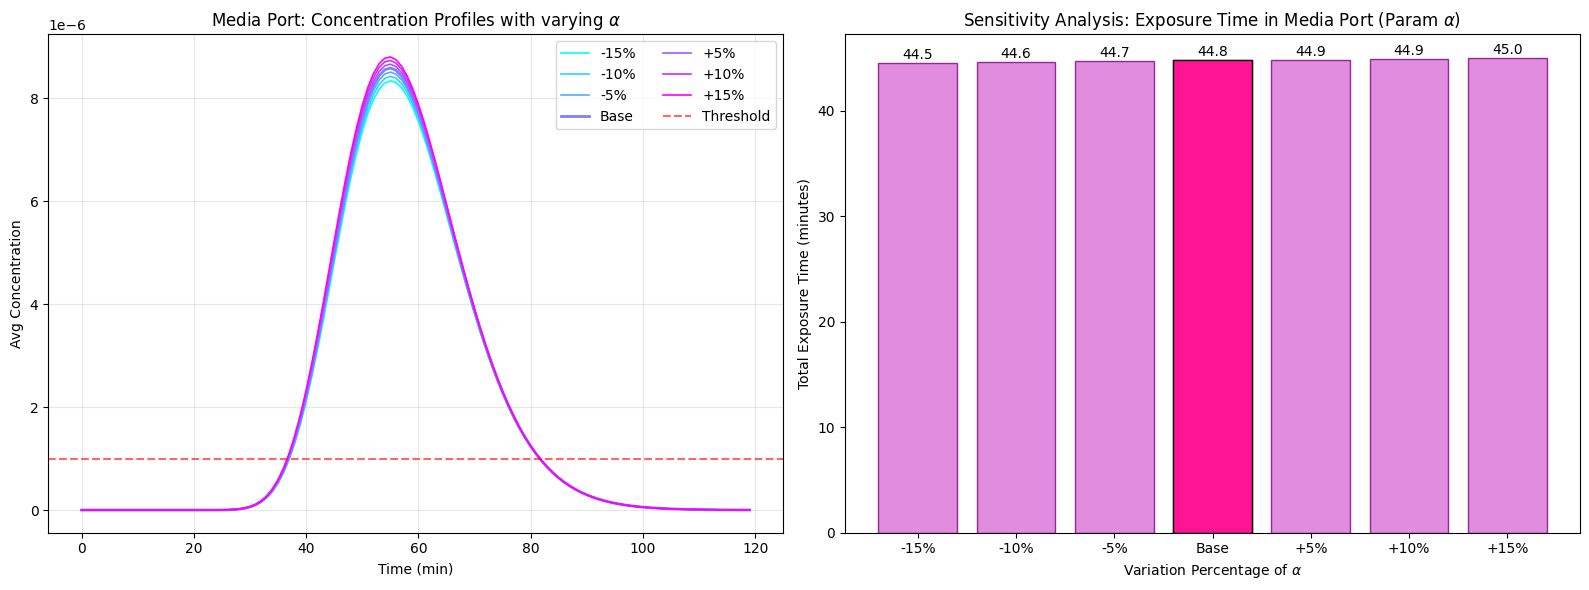


--- Alpha 灵敏性分析结果汇总 (Media Port) ---
Variation  Alpha_Value  Exposure_Time_Min
     -15%         0.34              44.55
     -10%         0.36              44.60
      -5%         0.38              44.70
     Base         0.40              44.80
      +5%         0.42              44.85
     +10%         0.44              44.90
     +15%         0.46              45.00


In [7]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# ================= 1. 模拟引擎函数化 (针对 alpha 暴露时长优化) =================
def simulate_alpha_exposure(alpha_val, threshold=1e-6):
    """
    alpha_val: 待测试的各向异性系数
    threshold: 暴露浓度阈值
    """
    dx, dy, dz = 20, 20, 10
    nx, ny, nz = 101, 101, 71
    dt = 3.0   
    total_time = 7200  
    steps = int(total_time / dt)
    
    x_vec = np.linspace(-1000, 1000, nx)
    y_vec = np.linspace(-1000, 1000, ny)
    X, Y = np.meshgrid(x_vec, y_vec, indexing='ij')

    # Media Port 地理掩码
    mp_bounds = {"x": [-550, -300], "y": [0, 200]}
    mp_mask = (X >= mp_bounds["x"][0]) & (X <= mp_bounds["x"][1]) & \
              (Y >= mp_bounds["y"][0]) & (Y <= mp_bounds["y"][1])

    # 建筑物配置
    buildings_cfg = [
        {"name": "Media Port", "x": -420, "y": 80, "A": 2.5, "R": 150},
        {"name": "PR North", "x": 480, "y": 220, "A": 2.0, "R": 120},
        {"name": "PR East", "x": 550, "y": -120, "A": 2.2, "R": 180},
        {"name": "Boyawan", "x": -280, "y": -380, "A": 1.8, "R": 130},
        {"name": "Dijing Huayuan", "x": -550, "y": -250, "A": 2.1, "R": 140}
    ]
    Fbld = np.ones((nx, ny))
    for b in buildings_cfg:
        Fbld += b['A'] * np.exp(-((X - b['x'])**2 + (Y - b['y'])**2) / b['R']**2)

    # 核心物理参数
    K0, theta = 9.32, np.deg2rad(131.8)
    
    # Kx, Ky 受 alpha 影响的计算公式
    Kx_2d = K0 * (np.cos(theta)**2 + alpha_val * np.sin(theta)**2) * Fbld
    Ky_2d = K0 * (np.sin(theta)**2 + alpha_val * np.cos(theta)**2) * Fbld
    Kz_vec = 2.0 * (1 - np.exp(-np.linspace(0, 700, nz) / 20.0))

    Kx = np.repeat(Kx_2d[:, :, np.newaxis], nz, axis=2)
    Ky = np.repeat(Ky_2d[:, :, np.newaxis], nz, axis=2)
    Kz = np.tile(Kz_vec, (nx, ny, 1))

    # 初始化浓度
    C = np.zeros((nx, ny, nz))
    C[nx//2, ny//2, int(600/dz)] = 1e15 / (dx*dy*dz) 
    
    exposure_count = 0 
    concentration_history = []

    for s in range(steps):
        C_old = C.copy()
        term_x = (Kx[1:-1, 1:-1, 1:-1] * (C_old[2:, 1:-1, 1:-1] - 2*C_old[1:-1, 1:-1, 1:-1] + C_old[:-2, 1:-1, 1:-1])) / dx**2
        term_y = (Ky[1:-1, 1:-1, 1:-1] * (C_old[1:-1, 2:, 1:-1] - 2*C_old[1:-1, 1:-1, 1:-1] + C_old[1:-1, :-2, 1:-1])) / dy**2
        term_z = (Kz[1:-1, 1:-1, 1:-1] * (C_old[1:-1, 1:-1, 2:] - 2*C_old[1:-1, 1:-1, 1:-1] + C_old[1:-1, 1:-1, :-2])) / dz**2

        C[1:-1, 1:-1, 1:-1] += dt * (term_x + term_y + term_z - 0.004 * C_old[1:-1, 1:-1, 1:-1])
        C[:, :, 0], C[:, :, -1] = C[:, :, 1], C[:, :, -2]

        avg_c = np.mean(C[:, :, 1][mp_mask])
        if avg_c > threshold:
            exposure_count += 1
            
        if s % 20 == 0:
            concentration_history.append(avg_c)
                
    exposure_time_min = (exposure_count * dt) / 60.0
    return exposure_time_min, concentration_history

# ================= 2. 执行 alpha 灵敏性分析 =================
alpha_base = 0.4
variations = [-0.15, -0.10, -0.05, 0, 0.05, 0.10, 0.15]
labels = ["-15%", "-10%", "-5%", "Base", "+5%", "+10%", "+15%"]

alpha_exposure_times = []
alpha_curves = {}

print(f"开始针对 Media Port 的 Alpha 灵敏性分析 (Base: {alpha_base})...")
for var, label in zip(variations, labels):
    current_alpha = alpha_base * (1 + var)
    print(f"正在计算工况 {label}: alpha = {current_alpha:.4f}")
    exp_time, curve = simulate_alpha_exposure(current_alpha)
    alpha_exposure_times.append(exp_time)
    alpha_curves[label] = curve

# ================= 3. 结果可视化 =================
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# 图1: 浓度曲线
time_axis = np.arange(len(alpha_curves["Base"])) * 1.0 
colors = plt.cm.cool(np.linspace(0, 1, len(labels)))

for idx, label in enumerate(labels):
    ax1.plot(time_axis, alpha_curves[label], label=label, color=colors[idx], 
             lw=2 if label=="Base" else 1.2)
ax1.axhline(1e-6, color='red', linestyle='--', alpha=0.6, label="Threshold")
ax1.set_title("Media Port: Concentration Profiles with varying $\\alpha$")
ax1.set_xlabel("Time (min)")
ax1.set_ylabel("Avg Concentration")
ax1.legend(ncol=2)
ax1.grid(alpha=0.3)

# 图2: 暴露时长柱状图
bars = ax2.bar(labels, alpha_exposure_times, color='orchid', edgecolor='purple', alpha=0.8)
ax2.bar("Base", alpha_exposure_times[3], color='deeppink', edgecolor='black') # 突出基准
ax2.set_title("Sensitivity Analysis: Exposure Time in Media Port (Param $\\alpha$)")
ax2.set_ylabel("Total Exposure Time (minutes)")
ax2.set_xlabel("Variation Percentage of $\\alpha$")

# 标注数值
for bar in bars:
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height + 0.1, f'{height:.1f}', ha='center', va='bottom')

plt.tight_layout()
plt.show()

# ================= 4. 统计汇总 =================
df_alpha_summary = pd.DataFrame({
    "Variation": labels,
    "Alpha_Value": [alpha_base * (1+v) for v in variations],
    "Exposure_Time_Min": alpha_exposure_times
})
print("\n--- Alpha 灵敏性分析结果汇总 (Media Port) ---")
print(df_alpha_summary.to_string(index=False))

kz和h0

开始垂直扩散参数灵敏性分析...
Kz_inf -15%: 0.00 min
Kz_inf -10%: 27.15 min
Kz_inf -5%: 37.50 min
Kz_inf +0%: 44.80 min
Kz_inf +5%: 50.45 min
Kz_inf +10%: 55.10 min
Kz_inf +15%: 59.05 min
h0 -15%: 46.15 min
h0 -10%: 45.70 min
h0 -5%: 45.25 min
h0 +0%: 44.80 min
h0 +5%: 44.30 min
h0 +10%: 43.80 min
h0 +15%: 43.30 min


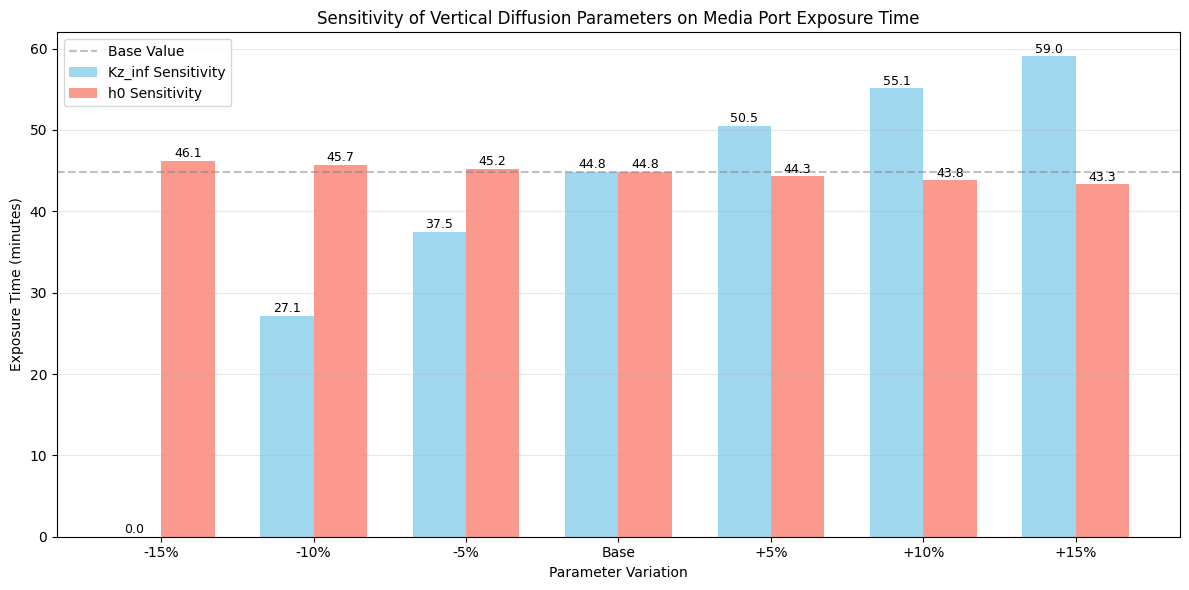


--- 垂直扩散参数灵敏性汇总 ---
  Variation  Kz_inf_ExpTime  h0_ExpTime
0      -15%            0.00       46.15
1      -10%           27.15       45.70
2       -5%           37.50       45.25
3      Base           44.80       44.80
4       +5%           50.45       44.30
5      +10%           55.10       43.80
6      +15%           59.05       43.30


In [8]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# ================= 1. 模拟引擎函数化 (支持 Kz_inf 和 h0 参数) =================
def simulate_Kz_exposure(kz_inf, h0, threshold=1e-6):
    """
    kz_inf: 垂直扩散系数最大值 (基准 2.0)
    h0: 垂直扩散特征高度 (基准 20.0)
    """
    dx, dy, dz = 20, 20, 10
    nx, ny, nz = 101, 101, 71
    dt = 3.0   
    total_time = 7200  
    steps = int(total_time / dt)
    
    x_vec = np.linspace(-1000, 1000, nx)
    y_vec = np.linspace(-1000, 1000, ny)
    z_vec = np.linspace(0, 700, nz)
    X, Y = np.meshgrid(x_vec, y_vec, indexing='ij')

    # Media Port 掩码
    mp_bounds = {"x": [-550, -300], "y": [0, 200]}
    mp_mask = (X >= mp_bounds["x"][0]) & (X <= mp_bounds["x"][1]) & \
              (Y >= mp_bounds["y"][0]) & (Y <= mp_bounds["y"][1])

    # 建筑物场
    buildings_cfg = [
        {"name": "Media Port", "x": -420, "y": 80, "A": 2.5, "R": 150},
        {"name": "PR North", "x": 480, "y": 220, "A": 2.0, "R": 120},
        {"name": "PR East", "x": 550, "y": -120, "A": 2.2, "R": 180},
        {"name": "Boyawan", "x": -280, "y": -380, "A": 1.8, "R": 130},
        {"name": "Dijing Huayuan", "x": -550, "y": -250, "A": 2.1, "R": 140}
    ]
    Fbld = np.ones((nx, ny))
    for b in buildings_cfg:
        Fbld += b['A'] * np.exp(-((X - b['x'])**2 + (Y - b['y'])**2) / b['R']**2)

    # 水平扩散参数 (保持基准)
    K0, theta, alpha = 9.32, np.deg2rad(131.8), 0.4
    Kx_2d = K0 * (np.cos(theta)**2 + alpha * np.sin(theta)**2) * Fbld
    Ky_2d = K0 * (np.sin(theta)**2 + alpha * np.cos(theta)**2) * Fbld
    
    # --- 垂直扩散参数 Kz ---
    Kz_vec = kz_inf * (1 - np.exp(-z_vec / h0))

    Kx = np.repeat(Kx_2d[:, :, np.newaxis], nz, axis=2)
    Ky = np.repeat(Ky_2d[:, :, np.newaxis], nz, axis=2)
    Kz = np.tile(Kz_vec, (nx, ny, 1))

    # 初始化浓度
    C = np.zeros((nx, ny, nz))
    C[nx//2, ny//2, int(600/dz)] = 1e15 / (dx*dy*dz) 
    
    exposure_count = 0 
    for s in range(steps):
        C_old = C.copy()
        term_x = (Kx[1:-1, 1:-1, 1:-1] * (C_old[2:, 1:-1, 1:-1] - 2*C_old[1:-1, 1:-1, 1:-1] + C_old[:-2, 1:-1, 1:-1])) / dx**2
        term_y = (Ky[1:-1, 1:-1, 1:-1] * (C_old[1:-1, 2:, 1:-1] - 2*C_old[1:-1, 1:-1, 1:-1] + C_old[1:-1, :-2, 1:-1])) / dy**2
        term_z = (Kz[1:-1, 1:-1, 1:-1] * (C_old[1:-1, 1:-1, 2:] - 2*C_old[1:-1, 1:-1, 1:-1] + C_old[1:-1, 1:-1, :-2])) / dz**2

        C[1:-1, 1:-1, 1:-1] += dt * (term_x + term_y + term_z - 0.004 * C_old[1:-1, 1:-1, 1:-1])
        C[:, :, 0], C[:, :, -1] = C[:, :, 1], C[:, :, -2]

        if np.mean(C[:, :, 1][mp_mask]) > threshold:
            exposure_count += 1
                
    return (exposure_count * dt) / 60.0

# ================= 2. 执行双参数灵敏性分析 =================
kz_inf_base = 2.0
h0_base = 20.0
variations = [-0.15, -0.10, -0.05, 0, 0.05, 0.10, 0.15]
labels = ["-15%", "-10%", "-5%", "Base", "+5%", "+10%", "+15%"]

kz_inf_results = []
h0_results = []

print("开始垂直扩散参数灵敏性分析...")

# 分析 kz_inf
for var in variations:
    res = simulate_Kz_exposure(kz_inf_base * (1 + var), h0_base)
    kz_inf_results.append(res)
    print(f"Kz_inf {var:+.0%}: {res:.2f} min")

# 分析 h0
for var in variations:
    res = simulate_Kz_exposure(kz_inf_base, h0_base * (1 + var))
    h0_results.append(res)
    print(f"h0 {var:+.0%}: {res:.2f} min")

# ================= 3. 可视化对比展示 =================
plt.figure(figsize=(12, 6))

x = np.arange(len(labels))
width = 0.35

plt.bar(x - width/2, kz_inf_results, width, label='Kz_inf Sensitivity', color='skyblue', alpha=0.8)
plt.bar(x + width/2, h0_results, width, label='h0 Sensitivity', color='salmon', alpha=0.8)

# 装饰
plt.axhline(kz_inf_results[3], color='gray', linestyle='--', alpha=0.5, label='Base Value')
plt.xticks(x, labels)
plt.title("Sensitivity of Vertical Diffusion Parameters on Media Port Exposure Time")
plt.ylabel("Exposure Time (minutes)")
plt.xlabel("Parameter Variation")
plt.legend()
plt.grid(axis='y', alpha=0.3)

# 数值标注
for i, (v1, v2) in enumerate(zip(kz_inf_results, h0_results)):
    plt.text(i - width/2, v1 + 0.1, f'{v1:.1f}', ha='center', va='bottom', fontsize=9)
    plt.text(i + width/2, v2 + 0.1, f'{v2:.1f}', ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()

# ================= 4. 输出数据表 =================
df_kz = pd.DataFrame({
    "Variation": labels,
    "Kz_inf_ExpTime": kz_inf_results,
    "h0_ExpTime": h0_results
})
print("\n--- 垂直扩散参数灵敏性汇总 ---")
print(df_kz)